# AutoML for wage prediction

## Automatic Machine Learning with H2O AutoML using Wage Data from 2015

We illustrate how to predict an outcome variable Y in a high-dimensional setting, using the AutoML package *H2O* that covers the complete pipeline from the raw dataset to the deployable machine learning model. In last few years, AutoML or automated machine learning has become widely popular among data science community. 

We can use AutoML as a benchmark and compare it to the methods that we used in the previous notebook where we applied one machine learning method after the other.

In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
import pyreadr
import os
from urllib.request import urlopen
from sklearn import preprocessing
import patsy
from h2o.automl import H2OAutoML

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

In [2]:
#pip install h2o

In [3]:
# load the H2O package
import h2o

# start h2o cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 .

 connected.


H2O_cluster_uptime:,4 hours 17 mins
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_User_fi8ht0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.574 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [4]:
link="https://raw.githubusercontent.com/d2cml-ai/14.388_py/main/data/wage2015_subsample_inference.Rdata"
response = urlopen(link)
content = response.read()
fhandle = open( 'wage2015_subsample_inference.Rdata', 'wb')
fhandle.write(content)
fhandle.close()
result = pyreadr.read_r("wage2015_subsample_inference.Rdata")
os.remove("wage2015_subsample_inference.Rdata")

# Extracting the data frame from rdata_read
data = result[ 'data' ]
n = data.shape[0]
type(data)

pandas.core.frame.DataFrame

In [5]:
# Import relevant packages for splitting data
import random
import math

# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(0)
random = np.random.randint(0, data.shape[0], size=math.floor(data.shape[0]))
data["random"] = random
random    # the array does not change 
data_2 = data.sort_values(by=['random'])

In [6]:
# Create training and testing sample 
train = data_2[ : math.floor(n*3/4)]    # training sample
test =  data_2[ math.floor(n*3/4) : ]   # testing sample
print(train.shape)
print(test.shape)

(3862, 21)
(1288, 21)


In [7]:
# start h2o cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 .

 connected.


H2O_cluster_uptime:,4 hours 17 mins
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_User_fi8ht0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.574 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [8]:
# convert data as h2o type
train_h = h2o.H2OFrame(train)
test_h = h2o.H2OFrame(test)

# have a look at the data
train_h.describe()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:3862
Cols:21




,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2,random
type,real,real,int,int,int,int,int,int,int,int,int,int,real,real,real,real,int,int,int,int,int
mins,3.021978021978022,1.1059115911497213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,370.0,2.0,0.0
mean,23.465417731467202,2.969427791239379,0.446918694976696,0.023562920766442258,0.24702226825479026,0.2780942516830658,0.3125323666494045,0.13878819264629724,0.2553081305023304,0.29829104091144487,0.21569135163127914,0.23070947695494562,13.672190574831728,2.9923032107716137,8.15417316157433,24.849760334671146,5243.418436043504,11.69135163127914,6667.996116002073,13.333764888658706,1914.2263076126374
maxs,528.845673076923,6.270696655981913,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,47.0,22.09,103.823,487.9681,100000.0,22.0,100000.0,22.0,3825.0
sigma,21.430085743506766,0.5750893708933925,0.4972387709704293,0.15170256601034887,0.4313356487428773,0.44811810407097313,0.46358551980855045,0.3457701367976389,0.436090737870262,0.45756716236312467,0.4113543571812672,0.4213414081729523,10.598613687032655,3.987480265404191,14.424744487903597,53.27996156215637,11579.91114662104,6.9783416585657125,5588.264282354911,5.691380293915183,1104.7025392074318
zeros,0,0,2136,3771,2908,2788,2655,3326,2876,2710,3029,2971,48,48,48,48,0,0,0,0,3
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,26.442307692307693,3.274965291519244,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.0,8.41,24.389,70.7281,340.0,1.0,8660.0,20.0,0.0
1,19.23076923076923,2.9565115604007097,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,33.5,11.2225,37.595375,125.94450625,9620.0,22.0,1870.0,5.0,0.0
2,48.07692307692308,3.872802292274865,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.04,0.008,0.0016,3060.0,10.0,8190.0,18.0,0.0


In [9]:
# define the variables
y = 'lwage'

data_columns = list(data)
no_relev_col = ['wage','occ2', 'ind2', 'random', 'lwage']

# This gives us: new_list = ['carrot' , 'lemon']
x = [col for col in data_columns if col not in no_relev_col]


In [10]:
# run AutoML for 10 base models and a maximal runtime of 100 seconds
# Run AutoML for 30 seconds
aml = H2OAutoML(max_runtime_secs = 100, max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = train_h, leaderboard_frame = test_h)


AutoML progress: |█


05:18:32.78: AutoML: XGBoost is not available; skipping it.



██

██

███

███

████

████████████████████████████████████████████████| (done) 100%


Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_3_20220804_51832

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.14953139924291178
RMSE: 0.38669290042993004
MAE: 0.294832254609963
RMSLE: 0.0995743628913442
R^2: 0.5477545769977904
Mean Residual Deviance: 0.14953139924291178
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 577.4902638761253
AIC: 3639.1200565941963

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.21847789952851338
RMSE: 0.46741619519279964
MAE: 0.35554760045970846
RMSLE: 0.11935300428309502
R^2: 0.339231555451349
Mean Residual Deviance: 0.21847789952851338
Null degrees of freedom: 3861
Residual degrees of freedom: 3853
Null deviance: 1277.1043650451534
Residual deviance: 843.7616479791186
AIC: 5105.507284326104

Cross-Validation Metrics

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.355541,0.011157,0.358896,0.365684,0.336852,0.354897,0.361377
1,mean_residual_deviance,0.218662,0.018184,0.232286,0.226297,0.191559,0.208794,0.234372
2,mse,0.218662,0.018184,0.232286,0.226297,0.191559,0.208794,0.234372
3,null_deviance,255.420870,18.944805,270.143950,279.337650,235.192600,252.053120,240.377060
4,r2,0.339145,0.024715,0.331879,0.342868,0.367003,0.352533,0.301443
5,residual_deviance,168.746690,14.014451,180.486480,183.527040,148.841520,163.068190,167.810170
6,rmse,0.467280,0.019707,0.481961,0.475707,0.437675,0.456940,0.484120
7,rmsle,0.119307,0.004621,0.122467,0.121303,0.111312,0.119405,0.122048


In [11]:
# AutoML Leaderboard
lb = aml.leaderboard
print(lb)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_3_20220804_51832,0.470537,0.221405,0.353883,0.12028,0.221405
GBM_2_AutoML_3_20220804_51832,0.471849,0.222642,0.355941,0.12074,0.222642
GBM_5_AutoML_3_20220804_51832,0.47191,0.222699,0.35582,0.120501,0.222699
StackedEnsemble_BestOfFamily_1_AutoML_3_20220804_51832,0.473019,0.223747,0.356456,0.12106,0.223747
GBM_3_AutoML_3_20220804_51832,0.474585,0.22523,0.359309,0.121264,0.22523
GBM_1_AutoML_3_20220804_51832,0.478149,0.228626,0.362211,0.122278,0.228626
GBM_4_AutoML_3_20220804_51832,0.479072,0.22951,0.362916,0.122456,0.22951
GBM_grid_1_AutoML_3_20220804_51832_model_1,0.48001,0.23041,0.36381,0.122671,0.23041
XRT_1_AutoML_3_20220804_51832,0.491218,0.241295,0.375089,0.125318,0.241295
DRF_1_AutoML_3_20220804_51832,0.50224,0.252245,0.382606,0.12847,0.252245


We see that two Stacked Ensembles are at the top of the leaderboard. Stacked Ensembles often outperform a single model. The out-of-sample (test) MSE of the leading model is given by

In [12]:
aml.leaderboard['mse'][0,0]

0.2214048934829345

The in-sample performance can be evaluated by

In [13]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_3_20220804_51832

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.14953139924291178
RMSE: 0.38669290042993004
MAE: 0.294832254609963
RMSLE: 0.0995743628913442
R^2: 0.5477545769977904
Mean Residual Deviance: 0.14953139924291178
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 577.4902638761253
AIC: 3639.1200565941963

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.21847789952851338
RMSE: 0.46741619519279964
MAE: 0.35554760045970846
RMSLE: 0.11935300428309502
R^2: 0.339231555451349
Mean Residual Deviance: 0.21847789952851338
Null degrees of freedom: 3861
Residual degrees of freedom: 3853
Null deviance: 1277.1043650451534
Residual deviance: 843.7616479791186
AIC: 5105.507284326104

Cross-Validation Metrics

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.355541,0.011157,0.358896,0.365684,0.336852,0.354897,0.361377
1,mean_residual_deviance,0.218662,0.018184,0.232286,0.226297,0.191559,0.208794,0.234372
2,mse,0.218662,0.018184,0.232286,0.226297,0.191559,0.208794,0.234372
3,null_deviance,255.420870,18.944805,270.143950,279.337650,235.192600,252.053120,240.377060
4,r2,0.339145,0.024715,0.331879,0.342868,0.367003,0.352533,0.301443
5,residual_deviance,168.746690,14.014451,180.486480,183.527040,148.841520,163.068190,167.810170
6,rmse,0.467280,0.019707,0.481961,0.475707,0.437675,0.456940,0.484120
7,rmsle,0.119307,0.004621,0.122467,0.121303,0.111312,0.119405,0.122048


This is in line with our previous results. To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model.  The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run.  This is often the top performing model on the leaderboard.

In [14]:
model_ids = h2o.as_list(aml.leaderboard['model_id'][0], use_pandas=True)


In [15]:
model = model_ids[model_ids['model_id'].str.contains("StackedEnsemble_AllModels")].values.tolist()
model_id = model[0][0]
model_id

'StackedEnsemble_AllModels_1_AutoML_3_20220804_51832'

In [16]:
se = h2o.get_model(model_id)
se

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_1_AutoML_3_20220804_51832

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.14953139924291178
RMSE: 0.38669290042993004
MAE: 0.294832254609963
RMSLE: 0.0995743628913442
R^2: 0.5477545769977904
Mean Residual Deviance: 0.14953139924291178
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 577.4902638761253
AIC: 3639.1200565941963

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.21847789952851338
RMSE: 0.46741619519279964
MAE: 0.35554760045970846
RMSLE: 0.11935300428309502
R^2: 0.339231555451349
Mean Residual Deviance: 0.21847789952851338
Null degrees of freedom: 3861
Residual degrees of freedom: 3853
Null deviance: 1277.1043650451534
Residual deviance: 843.7616479791186
AIC: 5105.507284326104

Cross-Validation Metrics

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.355541,0.011157,0.358896,0.365684,0.336852,0.354897,0.361377
1,mean_residual_deviance,0.218662,0.018184,0.232286,0.226297,0.191559,0.208794,0.234372
2,mse,0.218662,0.018184,0.232286,0.226297,0.191559,0.208794,0.234372
3,null_deviance,255.420870,18.944805,270.143950,279.337650,235.192600,252.053120,240.377060
4,r2,0.339145,0.024715,0.331879,0.342868,0.367003,0.352533,0.301443
5,residual_deviance,168.746690,14.014451,180.486480,183.527040,148.841520,163.068190,167.810170
6,rmse,0.467280,0.019707,0.481961,0.475707,0.437675,0.456940,0.484120
7,rmsle,0.119307,0.004621,0.122467,0.121303,0.111312,0.119405,0.122048


In [17]:
# Get the Stacked Ensemble metalearner model
metalearner = se.metalearner()
metalearner

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_AllModels_1_AutoML_3_20220804_51832


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.002325 )","nlambda = 100, lambda.max = 0.2219, lambda.min = 0.002325, lambda....",10,7,50,levelone_training_StackedEnsemble_AllModels_1_AutoML_3_20220804_51832




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.21731487482521683
RMSE: 0.46617043538304404
MAE: 0.35460963491810243
RMSLE: 0.11903948402841413
R^2: 0.3427490280462874
Mean Residual Deviance: 0.21731487482521683
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 839.2700465749874
AIC: 5082.893761881687

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.21847789952851338
RMSE: 0.46741619519279964
MAE: 0.35554760045970846
RMSLE: 0.11935300428309502
R^2: 0.339231555451349
Mean Residual Deviance: 0.21847789952851338
Null degrees of freedom: 3861
Residual degrees of freedom: 3853
Null deviance: 1277.1043650451534
Residual deviance: 843.7616479791186
AIC: 5105.507284326104

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.355541,0.011157,0.358896,0.365684,0.336852,0.354897,0.361377
1,mean_residual_deviance,0.218662,0.018184,0.232286,0.226297,0.191559,0.208794,0.234372
2,mse,0.218662,0.018184,0.232286,0.226297,0.191559,0.208794,0.234372
3,null_deviance,255.420870,18.944805,270.143950,279.337650,235.192600,252.053120,240.377060
4,r2,0.339145,0.024715,0.331879,0.342868,0.367003,0.352533,0.301443
5,residual_deviance,168.746690,14.014451,180.486480,183.527040,148.841520,163.068190,167.810170
6,rmse,0.467280,0.019707,0.481961,0.475707,0.437675,0.456940,0.484120
7,rmsle,0.119307,0.004621,0.122467,0.121303,0.111312,0.119405,0.122048



Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_xval,deviance_se,alpha,iterations,training_rmse,training_deviance,training_mae,training_r2
0,,2022-08-04 05:19:02,0.000 sec,1,",22E0",1,0.330642,0.330652,0.008216,0.5,NaN,,,,
1,,2022-08-04 05:19:02,0.000 sec,2,",2E0",5,0.316066,0.330609,0.008220,0.5,NaN,,,,
2,,2022-08-04 05:19:02,0.000 sec,3,",18E0",6,0.302049,0.330627,0.008216,0.5,NaN,,,,
3,,2022-08-04 05:19:02,0.009 sec,4,",17E0",6,0.289848,0.322157,0.008512,0.5,NaN,,,,
4,,2022-08-04 05:19:02,0.009 sec,5,",15E0",7,0.279287,0.307694,0.008407,0.5,5.0,0.528476,0.279287,0.407732,0.155318
5,,2022-08-04 05:19:02,0.011 sec,6,",14E0",7,0.270007,0.294801,0.008323,0.5,NaN,,,,
6,,2022-08-04 05:19:02,0.011 sec,7,",13E0",7,0.262086,0.283621,0.008253,0.5,NaN,,,,
7,,2022-08-04 05:19:02,0.011 sec,8,",12E0",7,0.255335,0.273875,0.008226,0.5,NaN,,,,
8,,2022-08-04 05:19:02,0.019 sec,9,",11E0",8,0.249586,0.265471,0.008206,0.5,NaN,,,,
9,,2022-08-04 05:19:02,0.019 sec,10,",96E-1",8,0.244598,0.258304,0.008188,0.5,10.0,0.494568,0.244598,0.377588,0.260234



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,GBM_5_AutoML_3_20220804_51832,1.593116e-01,1.000000,0.469498
1,GBM_3_AutoML_3_20220804_51832,6.467549e-02,0.405968,0.190601
2,GBM_1_AutoML_3_20220804_51832,4.807065e-02,0.301740,0.141666
3,GBM_grid_1_AutoML_3_20220804_51832_model_1,4.483997e-02,0.281461,0.132145
4,GBM_4_AutoML_3_20220804_51832,2.105824e-02,0.132183,0.062059
5,DeepLearning_1_AutoML_3_20220804_51832,1.367028e-03,0.008581,0.004029
6,DRF_1_AutoML_3_20220804_51832,6.541608e-07,0.000004,0.000002
7,GBM_2_AutoML_3_20220804_51832,0.000000e+00,0.000000,0.000000
8,XRT_1_AutoML_3_20220804_51832,0.000000e+00,0.000000,0.000000
9,GLM_1_AutoML_3_20220804_51832,0.000000e+00,0.000000,0.000000


Examine the variable importance of the metalearner (combiner) algorithm in the ensemble. This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM.

The table above gives us the variable importance of the metalearner in the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM. 


In [18]:
metalearner.coef_norm()

{'Intercept': 2.969427791239396,
 'GBM_2_AutoML_3_20220804_51832': 0.0,
 'GBM_5_AutoML_3_20220804_51832': 0.15931159666809516,
 'GBM_3_AutoML_3_20220804_51832': 0.06467548543296833,
 'GBM_1_AutoML_3_20220804_51832': 0.04807065170587735,
 'GBM_4_AutoML_3_20220804_51832': 0.021058238337922783,
 'GBM_grid_1_AutoML_3_20220804_51832_model_1': 0.04483996535251986,
 'XRT_1_AutoML_3_20220804_51832': 0.0,
 'DRF_1_AutoML_3_20220804_51832': 6.541608387958219e-07,
 'DeepLearning_1_AutoML_3_20220804_51832': 0.0013670278919920829,
 'GLM_1_AutoML_3_20220804_51832': 0.0}

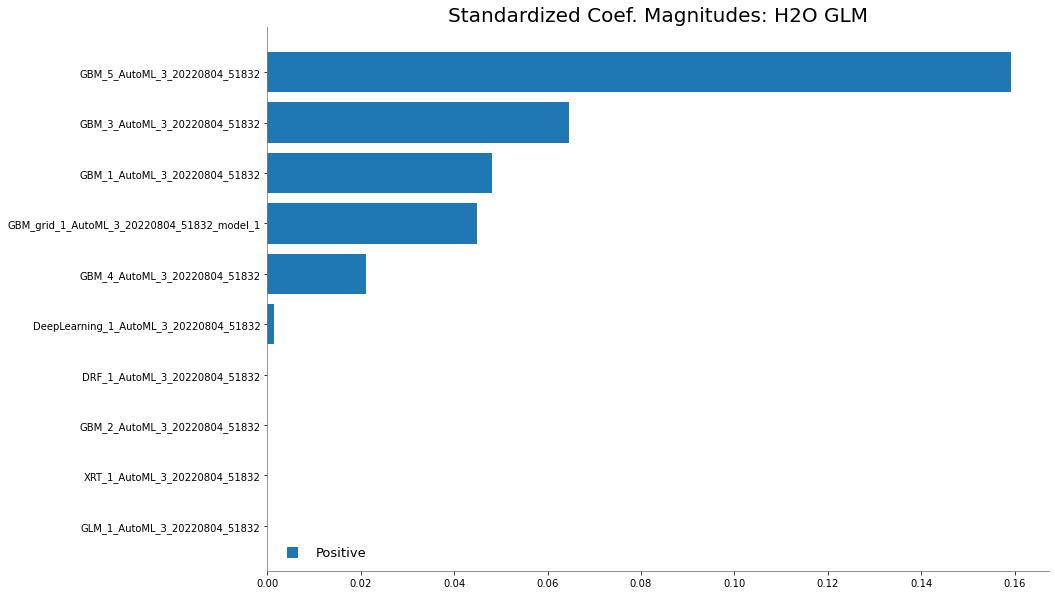

In [19]:
metalearner.std_coef_plot()

In [20]:
h2o.get_model(model_id).metalearner()

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_AllModels_1_AutoML_3_20220804_51832


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.002325 )","nlambda = 100, lambda.max = 0.2219, lambda.min = 0.002325, lambda....",10,7,50,levelone_training_StackedEnsemble_AllModels_1_AutoML_3_20220804_51832




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.21731487482521683
RMSE: 0.46617043538304404
MAE: 0.35460963491810243
RMSLE: 0.11903948402841413
R^2: 0.3427490280462874
Mean Residual Deviance: 0.21731487482521683
Null degrees of freedom: 3861
Residual degrees of freedom: 3854
Null deviance: 1276.9399854672324
Residual deviance: 839.2700465749874
AIC: 5082.893761881687

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.21847789952851338
RMSE: 0.46741619519279964
MAE: 0.35554760045970846
RMSLE: 0.11935300428309502
R^2: 0.339231555451349
Mean Residual Deviance: 0.21847789952851338
Null degrees of freedom: 3861
Residual degrees of freedom: 3853
Null deviance: 1277.1043650451534
Residual deviance: 843.7616479791186
AIC: 5105.507284326104

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.355541,0.011157,0.358896,0.365684,0.336852,0.354897,0.361377
1,mean_residual_deviance,0.218662,0.018184,0.232286,0.226297,0.191559,0.208794,0.234372
2,mse,0.218662,0.018184,0.232286,0.226297,0.191559,0.208794,0.234372
3,null_deviance,255.420870,18.944805,270.143950,279.337650,235.192600,252.053120,240.377060
4,r2,0.339145,0.024715,0.331879,0.342868,0.367003,0.352533,0.301443
5,residual_deviance,168.746690,14.014451,180.486480,183.527040,148.841520,163.068190,167.810170
6,rmse,0.467280,0.019707,0.481961,0.475707,0.437675,0.456940,0.484120
7,rmsle,0.119307,0.004621,0.122467,0.121303,0.111312,0.119405,0.122048



Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_xval,deviance_se,alpha,iterations,training_rmse,training_deviance,training_mae,training_r2
0,,2022-08-04 05:19:02,0.000 sec,1,",22E0",1,0.330642,0.330652,0.008216,0.5,NaN,,,,
1,,2022-08-04 05:19:02,0.000 sec,2,",2E0",5,0.316066,0.330609,0.008220,0.5,NaN,,,,
2,,2022-08-04 05:19:02,0.000 sec,3,",18E0",6,0.302049,0.330627,0.008216,0.5,NaN,,,,
3,,2022-08-04 05:19:02,0.009 sec,4,",17E0",6,0.289848,0.322157,0.008512,0.5,NaN,,,,
4,,2022-08-04 05:19:02,0.009 sec,5,",15E0",7,0.279287,0.307694,0.008407,0.5,5.0,0.528476,0.279287,0.407732,0.155318
5,,2022-08-04 05:19:02,0.011 sec,6,",14E0",7,0.270007,0.294801,0.008323,0.5,NaN,,,,
6,,2022-08-04 05:19:02,0.011 sec,7,",13E0",7,0.262086,0.283621,0.008253,0.5,NaN,,,,
7,,2022-08-04 05:19:02,0.011 sec,8,",12E0",7,0.255335,0.273875,0.008226,0.5,NaN,,,,
8,,2022-08-04 05:19:02,0.019 sec,9,",11E0",8,0.249586,0.265471,0.008206,0.5,NaN,,,,
9,,2022-08-04 05:19:02,0.019 sec,10,",96E-1",8,0.244598,0.258304,0.008188,0.5,10.0,0.494568,0.244598,0.377588,0.260234



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,GBM_5_AutoML_3_20220804_51832,1.593116e-01,1.000000,0.469498
1,GBM_3_AutoML_3_20220804_51832,6.467549e-02,0.405968,0.190601
2,GBM_1_AutoML_3_20220804_51832,4.807065e-02,0.301740,0.141666
3,GBM_grid_1_AutoML_3_20220804_51832_model_1,4.483997e-02,0.281461,0.132145
4,GBM_4_AutoML_3_20220804_51832,2.105824e-02,0.132183,0.062059
5,DeepLearning_1_AutoML_3_20220804_51832,1.367028e-03,0.008581,0.004029
6,DRF_1_AutoML_3_20220804_51832,6.541608e-07,0.000004,0.000002
7,GBM_2_AutoML_3_20220804_51832,0.000000e+00,0.000000,0.000000
8,XRT_1_AutoML_3_20220804_51832,0.000000e+00,0.000000,0.000000
9,GLM_1_AutoML_3_20220804_51832,0.000000e+00,0.000000,0.000000


## Generating Predictions Using Leader Model

We can also generate predictions on a test sample using the leader model object.

In [21]:
pred = aml.predict(test_h)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
2.88156
3.31904
3.07437
2.72129
2.51465
3.12459
3.17614
3.74251
2.57992
3.3026


This allows us to estimate the out-of-sample (test) MSE and the standard error as well.

In [22]:
pred_2 = pred.as_data_frame()
pred_aml = pred_2.to_numpy()

In [23]:
Y_test = test_h['lwage'].as_data_frame().to_numpy()

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [25]:
resid_basic = (Y_test-pred_aml)**2

MSE_aml_basic = sm.OLS( resid_basic , np.ones( resid_basic.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_aml_basic

Coef.       0.221405
Std.Err.    0.012923
Name: const, dtype: float64

We observe both a lower MSE and a lower standard error compared to our previous results (see [here](https://www.kaggle.com/janniskueck/pm3-notebook-newdata)).

### By using model_performance()
If needed, the standard model_performance() method can be applied to the AutoML leader model and a test set to generate an H2O model performance object.



In [26]:
perf = aml.leader.model_performance(test_h)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.22140489348293446
RMSE: 0.4705368141632857
MAE: 0.3538831803241703
RMSLE: 0.12028001142039113
R^2: 0.2838553741496075
Mean Residual Deviance: 0.22140489348293446
Null degrees of freedom: 1287
Residual degrees of freedom: 1280
Null deviance: 398.23902107893576
Residual deviance: 285.1695028060196
AIC: 1731.1880039637808
